In [14]:
import warnings
warnings.filterwarnings("ignore") 

In [15]:
from dask_gateway import Gateway
from dask.distributed import Client
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt()
client = Client(cluster)
cluster

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # Pythonic file-system for Google Cloud Storage
import os.path
import xesmf as xe
from scipy.signal import detrend

In [17]:
%matplotlib inline

# global vars for time-series

Time_months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec');
# plt.rcParams['figure.figsize'] = 12, 6
# %config InlineBackend.figure_format = 'retina'  #enabling 2x PNG matplotlib plots in the IPython notebook
colors = [[255, 255, 38], [255, 255, 38], [255,209, 35],
          [255, 157, 9], [255, 2, 2], [255, 148, 255],
          [255, 6, 255], [127, 245, 206], [26, 136, 255],
          [26, 136, 255], [17, 137, 17], [17, 137, 17],
          [8, 8, 126], [130, 55, 6], [112, 48, 160],
          [92, 92, 255], [92, 92, 255], [4, 2, 0]]
newcolors = []
for color in colors:
    newcolors.append([x/255.0 for x in color])
Colors=newcolors

var_names=['phyc','chl','phydiat','zooc','intpp','epc100',
           'fgco2','spco2','dfe','no3','si','rsntds']


plot_titles=['Biomass (mol/m3)','Chlorophyll (kg/m3)','Diatom (mol/m3)', 
             'Zooplankton (mol/m3)','Primary Production (mol/m2/s)','Export Production at 100m (mol/m2/s)',
             'Air-sea CO2 flux (donward +) (gram C /m2/year)','SpCO2 (ppm)', 'Iron - Fe (mol/m3)', 
             'Nitrate - NO3 (mol/m3)','Silica - Si (mol/m3)', 'Light - Surface Downward SW Radiation (W/m2)']

In [18]:
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
#         print(model, var, "found data")
    except:
        ds = []
        #print(model, var, "no data")
    return ds        

NameError: name 'ds' is not defined

In [19]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# models = ['CESM2', 'GFDL-CM4', 'GFDL-ESM4', 'CESM2-WACCM', 'IPSL-CM6A-LR', 'MRI-ESM2-0',
#           'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'UKESM1-0-LL',  'CanESM5', 'NorESM2-LM', 
#           'MPI-ESM1-2-HR', 'NorCPM1', 'MIROC-ES2L', 'CNRM-ESM2-1']
# models with ssp585 experiment
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR','GISS-E2-1-G','GISS-E2-1-G-CC','MIROC-ES2L',
          'NorCPM1', 'NorESM2-LM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','UKESM1-0-LL','CNRM-ESM2-1','ACCESS-ESM1-5','CanESM5-CanOE','CanESM5', 
          'EC-Earth3']

expe = 'historical'
freq = 'Omon'
start_year = '1995'
end_year = '2014'


In [20]:
# Another method for out grid:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0)),
                    }
                   )
ds_out

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    *empty*

In [26]:
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR','GISS-E2-1-G','GISS-E2-1-G-CC','MIROC-ES2L',
          'NorCPM1', 'NorESM2-LM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','UKESM1-0-LL','CNRM-ESM2-1','ACCESS-ESM1-5','CanESM5-CanOE','CanESM5', 
          'EC-Earth3']
# var_names=['phyc','chl','phydiat','zooc','tos']
# var_names = ['phyc', 'chl', 'phydiat', 'zooc','intpp','epc100','fgco2','spco2','dfe','no3','si','tos','omldamax','hfds','rsntds']
var_names = ['spco2']

expe = 'historical'
freq = 'Omon'
start_year = '1995'
end_year = '2014'

#new_models = ['GISS-E2-1-G', 'GISS-E2-1-G-CC']
# new_vars = ['phydiat']   # new models aren't working here. 
xxray_in = []
# true_var = 'phydiat'
for model in models:
    print(model)
    for var in var_names:
        vvar = var + 'os'
        xray = get_data(df, vvar, model, expe, freq)
        if isinstance(xray, xr.Dataset):
            xxray_in = xray
            
        else:
            vvar = var    
            xray = get_data(df, vvar, model, expe, freq)
            xxray_in= xray
        if isinstance(xxray_in, xr.Dataset):
                ds = xxray_in.sel(time=slice(start_year, end_year))[vvar]
            
                if 'latitude' in ds.coords:
                    ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
                if 'nav_lat' in ds.coords:
                    ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            
                if 'lev_partial' in ds.coords:
                    ds = ds.isel(lev_partial=0)
                if 'olevel' in ds.coords:
                    ds = ds.isel(olevel=0)
                if 'lev' in ds.coords:
                    ds = ds.isel(lev=0)
                
                if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                    if var == 'phyc' or var == 'chl' or var == 'phydiat' or var == 'zooc' or var == 'no3' or var == 'si' or var == 'dfe':
                        ds = ds.where(ds>=0)
                
                dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
                dsr._grid_in = None
                dsr._grid_out = None
                dsr_out0 = dsr(ds)
                dsr_out = xr.Dataset({var:dsr_out0})
            
                
                if dsr_out[var].shape[0]==240:
                    print(var)
                    ds_np = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(210,220))
                    dsm_np = ds_np[var].mean(dim='time',skipna=1)
                    anom_np = ds_np[var] - dsm_np
                    anom_np.load()
#                     anom_detrended_np = xr.apply_ufunc(detrend, anom_np.fillna(0), anom_np.chunk({"lon":45,"lat":45}), kwargs={'axis': 0}).where(~anom_np.isnull())
                    anom_detrended_np = xr.apply_ufunc(detrend, anom_np.fillna(0).chunk({"lon":45,"lat":45}), kwargs={'axis': 0},dask="parallelized", output_dtypes=[anom_np.dtype]).where(~anom_np.isnull())
                    detrend_np = anom_detrended_np + dsm_np
                    do_np = detrend_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
                    if var == 'spco2':
                        do_np = do_np / 0.101325
#                     if var == 'phyc' or var == 'phycos':
#                         do_np = do_np * 12000 # more info
#                     if var == 'phycdiat'or var == 'phycdiatos':
#                         do_np = do_np * 12000 # more info
                    if var == 'fgco2':
                        do_np = do_np * 3600 * 24 * 365 * 1000 / (44/12) 
                
                    savef_np = '/home/jovyan/save_co2/' + model + '_' + var + '_np.txt'
                    with open(savef_np, 'w') as npf:
                        for idata in do_np:
                            npf.write(str(idata) +"\n")
                
                    ds_na = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(325,335))
                    dsm_na = ds_na[var].mean(dim='time', skipna=1)
                    anom_na = ds_na[var] - dsm_na
                    anom_na.load()
                    anom_detrended_na = xr.apply_ufunc(detrend, anom_na.fillna(0),kwargs={'axis': 0}, dask="parallelized", output_dtypes=[anom_na.dtype]).where(~anom_na.isnull())
                    detrend_na = anom_detrended_na + dsm_na
                    do_na = detrend_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
                    if var == 'spco2':
                        do_na = do_na / 0.101325
#                     if var == 'phyc' or var == 'phycos':
#                         do_na = do_na * 12000 # more info
#                     if var == 'phycdiat'or var == 'phycdiatos':
#                         do_na = do_na * 12000 # more info
                    if var == 'fgco2':
                        do_na = do_na * 3600 * 24 * 365 * 1000 / (44/12) 
                
                    savef_na = '/home/jovyan/save_co2/' + model + '_' + var + '_na.txt'
                    with open(savef_na, 'w') as naf:
                        for idata in do_na:
                            naf.write(str(idata) +"\n")
                                        
#                 dsr.clean_weight_file()
                
#                 :~$ tar -czvf NA_NPssp585.tar.gz save

CESM2-WACCM
spco2
CESM2
spco2
GFDL-CM4
GFDL-ESM4
spco2
IPSL-CM6A-LR
spco2
GISS-E2-1-G
spco2
GISS-E2-1-G-CC
spco2
MIROC-ES2L
spco2
NorCPM1
spco2
NorESM2-LM
spco2
MPI-ESM1-2-HR
spco2
MPI-ESM1-2-LR
spco2
UKESM1-0-LL
spco2
CNRM-ESM2-1
spco2
ACCESS-ESM1-5
spco2
CanESM5-CanOE
spco2
CanESM5
spco2
EC-Earth3


In [22]:
%%time

for model in models:
    sparay = get_data(df, 'spco2', model, expe, freq)
    #print(sparay)
    if isinstance(sparay, xr.Dataset):
        staray = get_data(df, 'tos', model, expe, freq)
        #print(staray)
        if not isinstance(staray, xr.Dataset):
            print(model, 'no tos, try thetao')
            staray = get_data(df, 'thetao', model, expe, freq)
            #print(staray)
            if not isinstance(staray, xr.Dataset):
                print(model, 'no sst data')
                continue
    else:
        continue
    
    dsp = sparay.sel(time=slice(start_year, end_year))['spco2']
    
    if 'thetao' in staray:
        if 'lev_partial' in staray.coords:
            staray = staray.isel(lev_partial=0)
        if 'olevel' in staray.coords:
            staray = staray.isel(olevel=0)
        if 'lev' in staray.coords:
            staray = staray.isel(lev=0)
        if 'rho' in staray.coords:
            staray = staray.isel(rho=0)
        dst = staray.sel(time=slice(start_year, end_year))['thetao']
        
        #dst = dst.rename({'thetao':'tos'})
    else:
        dst = staray.sel(time=slice(start_year, end_year))['tos']
        
    if dst.shape[0] != 240:
        continue
    
    
    if 'latitude' in dsp.coords:
        dsp = dsp.rename({'longitude': 'lon', 'latitude': 'lat'})
        dst = dst.rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in dsp.coords:
        dsp = dsp.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
        dst = dst.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    
    mrp = xe.Regridder(dsp, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
    mrp._grid_in = None
    mrp._grid_out = None
    dsp_out = mrp(dsp)
    mrt = xe.Regridder(dst, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
    mrt._grid_in = None
    mrt._grid_out = None
    dst_out = mrt(dst)
    
    m_rg = xr.Dataset({'spco2':dsp_out, 'sst':dst_out})
    

    if m_rg['spco2'].shape[0]==240:
        if m_rg['sst'].shape[0]==240:
            print(m_rg['sst'].shape)
            
            ## PAPA site ##
            d_np = m_rg.sel(lat=slice(45,50)).sel(lon=slice(210,220))    
            
            msp_np = d_np['spco2'].mean(dim='time',skipna=1) 
            anomsp_np = d_np['spco2'] - msp_np
            mst_np = d_np['sst'].mean(dim='time',skipna=1)
            anomst_np = d_np['sst'] - mst_np
            
            anomsp_np.load()           
            anomsp_detrended_np = xr.apply_ufunc(detrend, anomsp_np.fillna(0), 
                                                 kwargs={'axis': 0}).where(~anomsp_np.isnull())
            dtsp_np = anomsp_detrended_np + msp_np   
            dtsp_np = dtsp_np / 0.101325 
            
            anomst_np.load()
            anomst_detrended_np = xr.apply_ufunc(detrend, anomst_np.fillna(0), 
                                                 kwargs={'axis': 0}).where(~anomst_np.isnull())
            dtst_np = anomst_detrended_np + mst_np      
            
            sp_temp_np = np.mean(dtsp_np) * np.exp(0.0423 * anomst_detrended_np)
            sp_ntemp_np = dtsp_np * np.exp( 0.0423 * (- anomst_detrended_np))       
            
            monsp_t_np = sp_temp_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            monsp_nt_np = sp_ntemp_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            sst_np = dtst_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values               
            
            savet_np = '/home/jovyan/save_co2/' + model + '_pco2-t_np.txt'
            with open(savet_np, 'w') as nptf:
                for idata in monsp_t_np:
                    nptf.write(str(idata) +"\n")        
            
            savent_np = '/home/jovyan/save_co2/' + model + '_pco2-nt_np.txt'
            with open(savent_np, 'w') as npntf:
                for idata in monsp_nt_np:
                    npntf.write(str(idata) +"\n")
            
            savesst_np = '/home/jovyan/save_co2/' + model + '_sst_np.txt'
            with open(savesst_np, 'w') as npsstf:
                for idata in sst_np:
                    npsstf.write(str(idata) +"\n")
                    
            
            ## NABA site ##
            d_na = m_rg.sel(lat=slice(45,50)).sel(lon=slice(325,335))
            
            msp_na = d_na['spco2'].mean(dim='time',skipna=1)
            anomsp_na = d_na['spco2'] - msp_na
            mst_na = d_na['sst'].mean(dim='time',skipna=1)
            anomst_na = d_na['sst'] - mst_na
            
            anomsp_na.load()
            anomsp_detrended_na = xr.apply_ufunc(detrend, anomsp_na.fillna(0), kwargs={'axis': 0}).where(~anomsp_na.isnull())
            dtsp_na = anomsp_detrended_na + msp_na
            dtsp_na = dtsp_na / 0.101325 
            
            anomst_na.load()
            anomst_detrended_na = xr.apply_ufunc(detrend, anomst_na.fillna(0), kwargs={'axis': 0}).where(~anomst_na.isnull())
            dtst_na = anomst_detrended_na + mst_na
            
            sp_temp_na = np.mean(dtsp_na) * np.exp(0.0423 * anomst_na)
            sp_ntemp_na = dtsp_na * np.exp( 0.0423 * (- anomst_na))
            
            monsp_t_na = sp_temp_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            monsp_nt_na = sp_ntemp_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            sst_na = dtst_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            
            savet_na = '/home/jovyan/save_co2/' + model + '_pco2-t_na.txt'
            with open(savet_na, 'w') as natf:
                for idata in monsp_t_na:
                    natf.write(str(idata) +"\n")
            
            savent_na = '/home/jovyan/save_co2/' + model + '_pco2-nt_na.txt'
            with open(savent_na, 'w') as nantf:
                for idata in monsp_nt_na:
                    nantf.write(str(idata) +"\n")
            
            savesst_na = '/home/jovyan/save_co2/' + model + '_sst_na.txt'
            with open(savesst_na, 'w') as nasstf:
                for idata in sst_na:
                    nasstf.write(str(idata) +"\n")
    
    
#     mrp.clean_weight_file()
#     mrt.clean_weight_file()

(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
(240, 181, 361)
CPU times: user 4min 54s, sys: 47 s, total: 5min 41s
Wall time: 14min 52s


In [23]:
pvars=['spco2', 'pco2-t', 'pco2-nt',
       'chl', 'sst', 'phyc',
       'dfe','no3']
ptitles=['pCO2 (ppm)', 'pCO2-T (ppm)', 'pCO2-nonT (ppm)', 
         'Chlorophyll (kg/m3)', 'SST (C)', 'Biomass (mol/m3)',
         'Iron - Fe (mol/m3)', 'Nitrate - NO3 (mol/m3)']  
pranges=[[270, 485], [270, 485], [270, 485], 
         [-0.1e-6, 5e-6], [4, 20], [-0.001,0.02],
         [-0.1e-6, 1e-6], [-0.001, 0.012]]

In [ ]:
%%time

fig = plt.figure(figsize=(15, 11))
ncol = 3
nrow = 3
i = 0
for var in pvars:
    
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    for model in models:
        
        ofn = 'save/' + str(model) + '_' + str(var) + '_np.txt'
        if os.path.exists(ofn):
            
            dm = []
            with open(ofn, "r") as rf:
                for line in rf:
                    dm.append(float(line.strip()))
            
            xmon = np.arange(1, 13)
            s = np.array(dm)
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = s * 0.001        # need more infromation
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -s             # need more infromation
                if var == 'fgco2':
                    s = s*(10**(-10))    # need more infromation
                if var == 'dfe':
                    xmon =[]
                    s = []        # need more infromation
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
            
        mi = mi +1
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.ylim(pranges[i-1])
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(ptitles[i-1], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.8, 0.01)) 
plt.suptitle('CMIP6 SpCO2 separation and seasonal cylces - North Pacific [45N-50N, 140W-150W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('pCO2_sep_NP.png', dpi=600)    


spco2
pco2-t
pco2-nt
CPU times: user 5.07 s, sys: 85.8 ms, total: 5.15 s
Wall time: 5.19 s


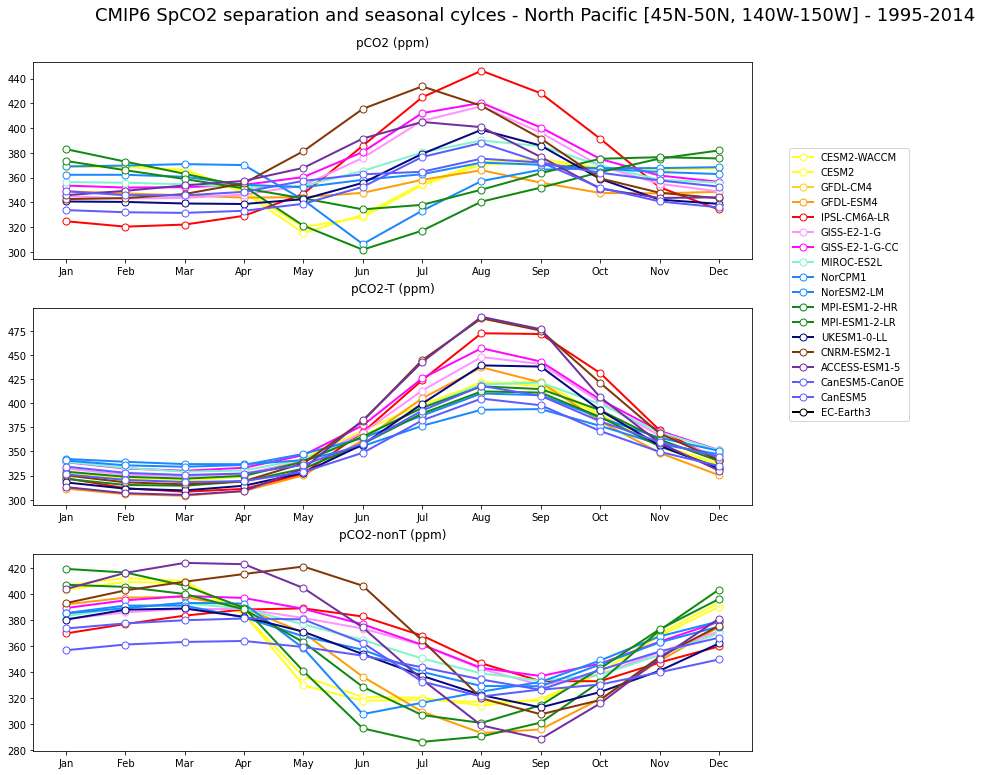

In [33]:
%%time
# this works
colors = [[255, 255, 38], [255, 255, 38], [255,209, 35],
          [255, 157, 9], [255, 2, 2], [255, 148, 255],
          [255, 6, 255], [127, 245, 206], [26, 136, 255],
          [26, 136, 255], [17, 137, 17], [17, 137, 17],
          [8, 8, 126], [130, 55, 6], [112, 48, 160],
          [92, 92, 255], [92, 92, 255], [4, 2, 0]]
newcolors = []
for color in colors:
    newcolors.append([x/255.0 for x in color])
Colors=newcolors
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR','GISS-E2-1-G','GISS-E2-1-G-CC','MIROC-ES2L',
          'NorCPM1', 'NorESM2-LM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','UKESM1-0-LL','CNRM-ESM2-1','ACCESS-ESM1-5','CanESM5-CanOE','CanESM5', 
          'EC-Earth3']
# pvars=['spco2', 'pco2-t', 'pco2-nt',
#        'chl', 'sst', 'phyc',
#        'dfe','no3']

pvars = ['spco2','pco2-t','pco2-nt']
# ptitles=['pCO2 (ppm)', 'pCO2-T (ppm)', 'pCO2-nonT (ppm)', 
#          'Chlorophyll (kg/m3)', 'SST (C)', 'Biomass (mol/m3)',
#          'Iron - Fe (mol/m3)', 'Nitrate - NO3 (mol/m3)']  

ptitles = ['pCO2 (ppm)', 'pCO2-T (ppm)', 'pCO2-nonT (ppm)']

# pranges=[[270, 485], [270, 485], [270, 485], 
#          [-0.1e-6, 5e-6], [4, 20], [-0.001,0.02],
#          [-0.1e-6, 1e-6], [-0.001, 0.012]]
pranges=[[700, 1500], [700,1500], [700,1500], 
         [-0.1e-6, 3e-6], [0, 25], [-0.001,0.02],
         [-0.1e-6, 1e-6], [-0.001, 0.018]]



fig = plt.figure(figsize=(15, 11))
ncol = 3
nrow = 1
i = 0
for var in pvars:
    print(var)
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    for model in models:
#         print(model)
        ofn = '/home/jovyan/save_co2/' + str(model) + '_' + str(var) + '_np.txt'
        if os.path.exists(ofn):
            
            dm = []
            with open(ofn, "r") as rf:
                for line in rf:
                    dm.append(float(line.strip()))
            
            xmon = np.arange(1, 13)
            s = np.array(dm)
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = s * 0.001        # need more infromation
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -s             # need more infromation
                if var == 'fgco2':
                    s = s*(10**(-10))    # need more infromation
                if var == 'dfe':
                    xmon =[]
                    s = []        # need more infromation
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='w', linewidth=2.0)
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='w', linewidth=2.0)
#         print(Colors[mi])    
        mi = mi +1
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
#     plt.ylim(pranges[i-1])
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(ptitles[i-1], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.7, top=0.91, hspace=0.25, wspace=1) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.85, 0.45)) 
plt.suptitle('CMIP6 SpCO2 separation and seasonal cylces - North Pacific [45N-50N, 140W-150W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('/home/jovyan/pCO2_sep_NP.png', dpi=600)    


spco2
pco2-t
pco2-nt
CPU times: user 5.09 s, sys: 59.9 ms, total: 5.15 s
Wall time: 5.21 s


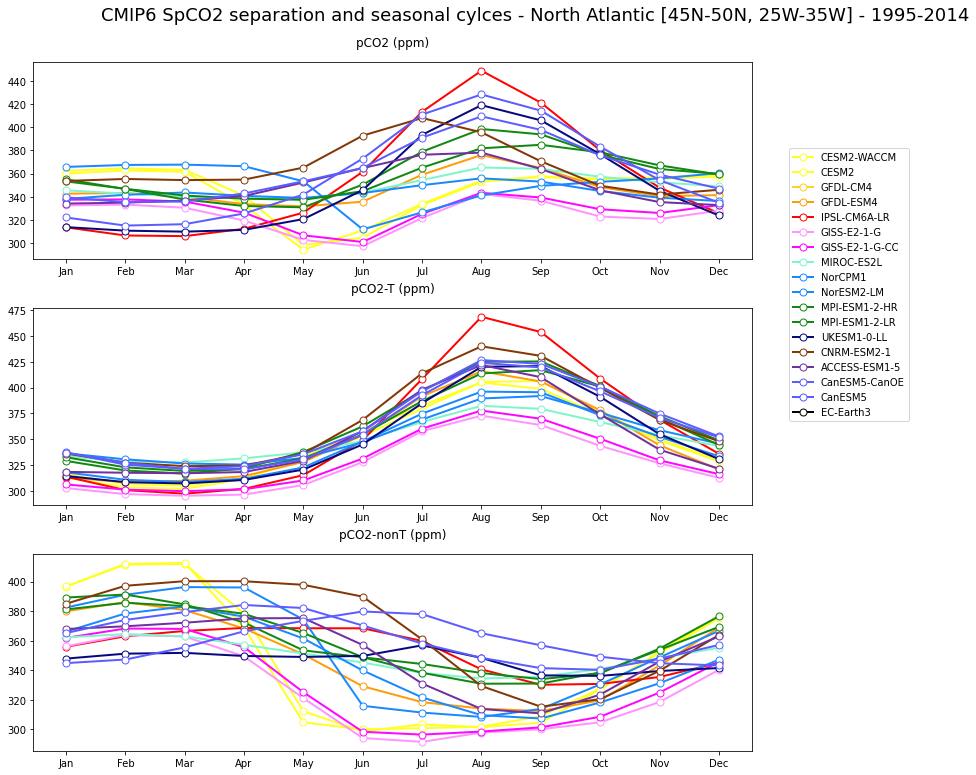

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/p

In [34]:
%%time
# this works
colors = [[255, 255, 38], [255, 255, 38], [255,209, 35],
          [255, 157, 9], [255, 2, 2], [255, 148, 255],
          [255, 6, 255], [127, 245, 206], [26, 136, 255],
          [26, 136, 255], [17, 137, 17], [17, 137, 17],
          [8, 8, 126], [130, 55, 6], [112, 48, 160],
          [92, 92, 255], [92, 92, 255], [4, 2, 0]]
newcolors = []
for color in colors:
    newcolors.append([x/255.0 for x in color])
Colors=newcolors
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR','GISS-E2-1-G','GISS-E2-1-G-CC','MIROC-ES2L',
          'NorCPM1', 'NorESM2-LM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','UKESM1-0-LL','CNRM-ESM2-1','ACCESS-ESM1-5','CanESM5-CanOE','CanESM5', 
          'EC-Earth3']
# pvars=['spco2', 'pco2-t', 'pco2-nt',
#        'chl', 'sst', 'phyc',
#        'dfe','no3']

pvars = ['spco2','pco2-t','pco2-nt']
# ptitles=['pCO2 (ppm)', 'pCO2-T (ppm)', 'pCO2-nonT (ppm)', 
#          'Chlorophyll (kg/m3)', 'SST (C)', 'Biomass (mol/m3)',
#          'Iron - Fe (mol/m3)', 'Nitrate - NO3 (mol/m3)']  

ptitles = ['pCO2 (ppm)', 'pCO2-T (ppm)', 'pCO2-nonT (ppm)']

# pranges=[[270, 485], [270, 485], [270, 485], 
#          [-0.1e-6, 5e-6], [4, 20], [-0.001,0.02],
#          [-0.1e-6, 1e-6], [-0.001, 0.012]]
pranges=[[700, 1500], [700,1500], [700,1500], 
         [-0.1e-6, 3e-6], [0, 25], [-0.001,0.02],
         [-0.1e-6, 1e-6], [-0.001, 0.018]]



fig = plt.figure(figsize=(15, 11))
ncol = 3
nrow = 1
i = 0
for var in pvars:
    print(var)
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    for model in models:
#         print(model)
        ofn = '/home/jovyan/save_co2/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofn):
            
            dm = []
            with open(ofn, "r") as rf:
                for line in rf:
                    dm.append(float(line.strip()))
            
            xmon = np.arange(1, 13)
            s = np.array(dm)
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = s * 0.001        # need more infromation
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -s             # need more infromation
                if var == 'fgco2':
                    s = s*(10**(-10))    # need more infromation
                if var == 'dfe':
                    xmon =[]
                    s = []        # need more infromation
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='w', linewidth=2.0)
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='w', linewidth=2.0)
#         print(Colors[mi])    
        mi = mi +1
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
#     plt.ylim(pranges[i-1])
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(ptitles[i-1], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.7, top=0.91, hspace=0.25, wspace=1) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.85, 0.45)) 
plt.suptitle('CMIP6 SpCO2 separation and seasonal cylces - North Atlantic [45N-50N, 25W-35W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('/home/jovyan/pCO2_sep_NA.png', dpi=600)    
